In [9]:
!pip install keras

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [19]:
!pip install tensorflow_datasets

  Obtaining dependency information for tensorflow_datasets from https://files.pythonhosted.org/packages/fe/18/4865973f5469cfe33bbe1cfc2f1918335eb44f4cc3d316c1bce22c1af2bc/tensorflow_datasets-4.9.4-py3-none-any.whl.metadata
  Using cached tensorflow_datasets-4.9.4-py3-none-any.whl.metadata (9.2 kB)
  Obtaining dependency information for etils[enp,epath,etree]>=0.9.0 from https://files.pythonhosted.org/packages/37/10/dd5b124f037a636783e416a2fe839edd7ec63c0dce7ce4f3c1da029aeb80/etils-1.7.0-py3-none-any.whl.metadata
  Using cached etils-1.7.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached promise-2.3-py3-none-any.whl
  Obtaining dependency information for tensorflow-metadata from https://files.pythonhosted.org/packages/41/23/3705c7139886c079ef4c0e3be56a5a1fb90e9ee413a4b7caaee0ee0ea6fe/tensorflow_metadata-1.14.0-py3-none-any.whl.metadata
  Using cached tensorflow_metadata-1.14.0-py3-none-any.whl.metadata (2.1 kB)
  Obtaining dependency information for importlib_resources from https://fil

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
tensorflow-intel 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.


In [23]:
#print(tfds.list_datasets())

In [24]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
     

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ASHISH KUMAR\tensorflow_datasets\tf_flowers\3.0.1.incompleteHT4ET9\tf_flowers-train.tfrecor…

Dataset tf_flowers downloaded and prepared to C:\Users\ASHISH KUMAR\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [25]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


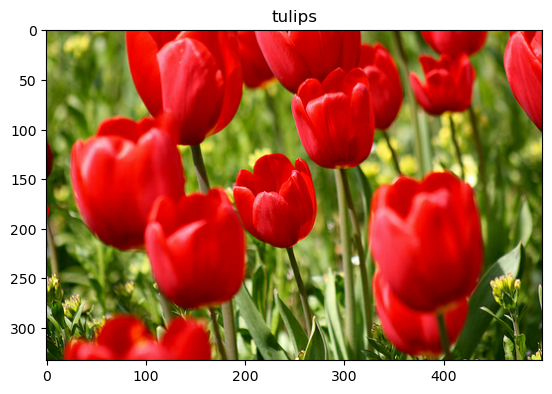

In [26]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [27]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

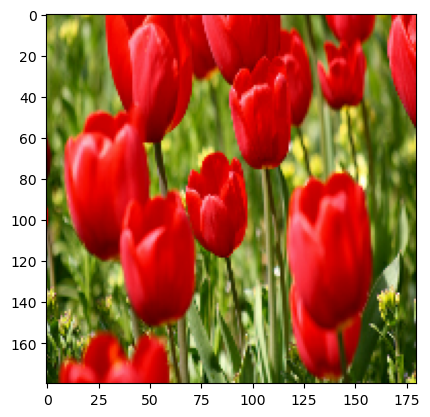

In [28]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [29]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())
     

Min and max pixel values: 0.0 1.0


In [30]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [31]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

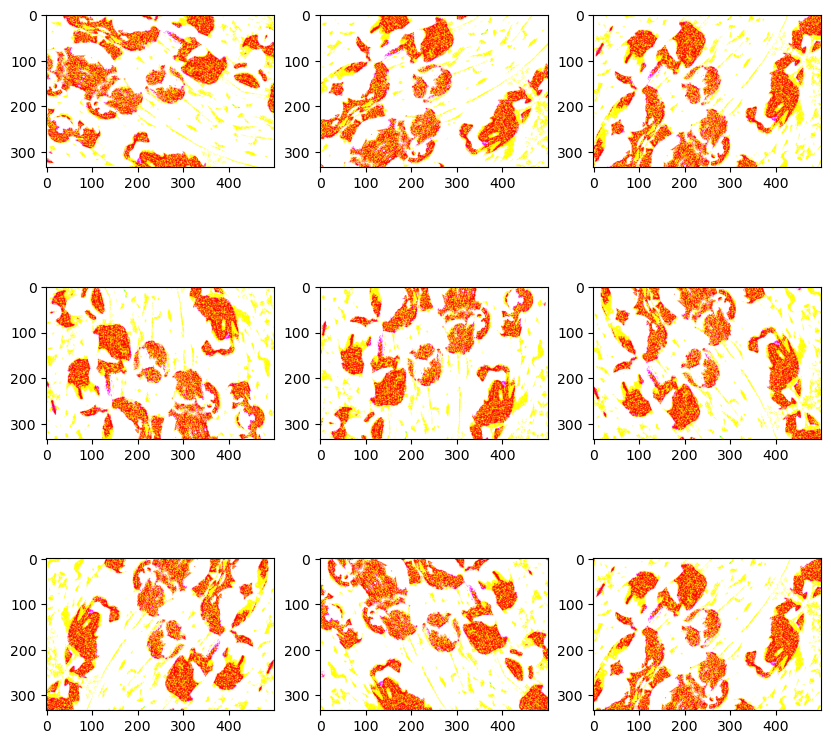

In [36]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("on")

In [37]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

In [38]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [39]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)
     


In [40]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [41]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
   

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.3444 - loss: 1.5009 - val_accuracy: 0.5613 - val_loss: 1.0995
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.5586 - loss: 1.0670 - val_accuracy: 0.6076 - val_loss: 0.9964
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.5974 - loss: 0.9836 - val_accuracy: 0.6076 - val_loss: 0.9885
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.6315 - loss: 0.9666 - val_accuracy: 0.6158 - val_loss: 0.9269
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.6583 - loss: 0.8597 - val_accuracy: 0.6649 - val_loss: 0.8651


In [44]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6249 - loss: 0.8322
Accuracy 0.640326976776123


In [45]:
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

In [46]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

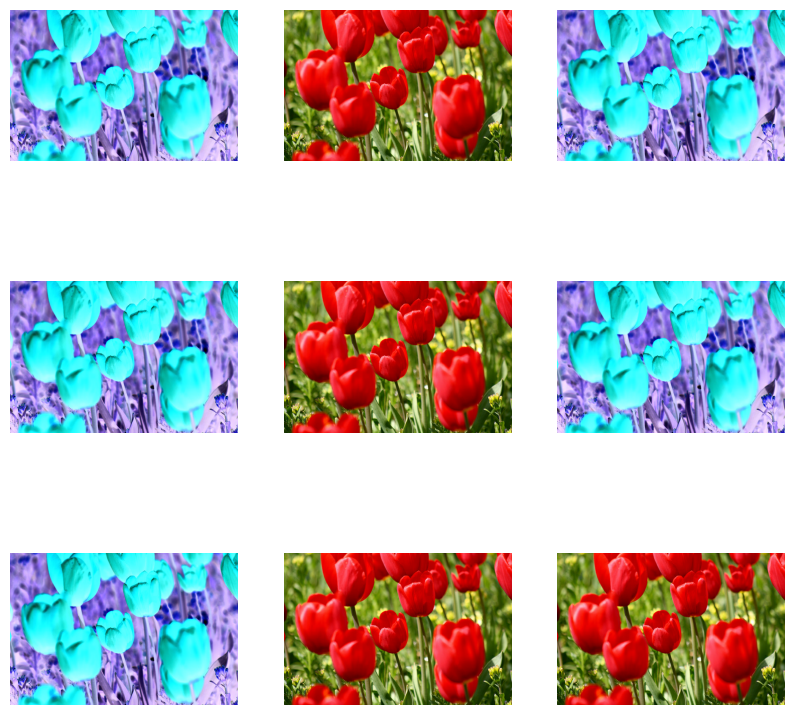

In [47]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [51]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
            super().__init__(**kwargs)
            self.factor = factor

    def call(self, x):
            return random_invert_img(x)
     

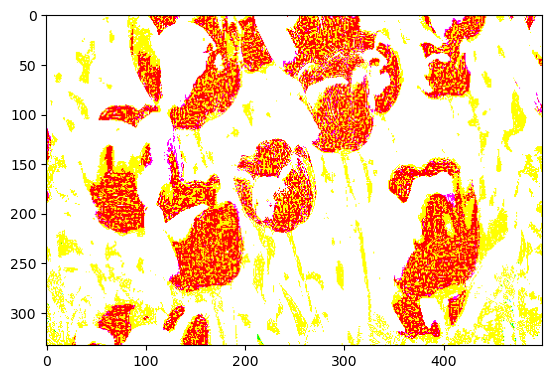

In [52]:
_ = plt.imshow(RandomInvert()(image)[0])

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat_image.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  